# Classification using CNN:  4 convolutional layer
The dataset consists of a training set and a testing set of images of clothing. Each image has its own unique ID. The dataset has 20 main categories which we need to classify the testing set into. 

**(1). Importing all the necessary modules:**

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import math 
import cv2 
from glob import glob 
import itertools

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Global variables
scale = 70
seed = 7

**(2). Getting the data and resizing the images:**

In [8]:
path_to_images = 'data/top10/*/*.jpg'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1

In [10]:
# Read images and resize them
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

**(3). Cleaning the images and removing the background:**
* Cleaning of the images is an intensive task. We will have to:
    * Convert the RGB image into HSV.
    * Blur the image to remove noise.
    * Create a mask to remove the background.

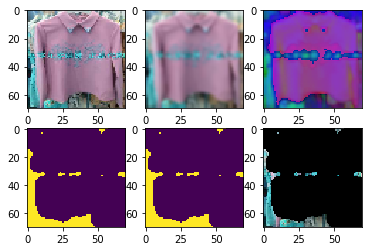

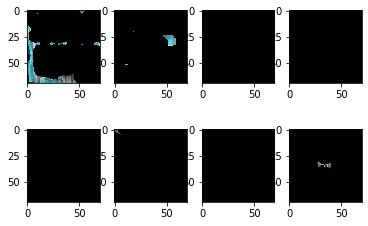

In [11]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    # Green Parameter
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # origional
        plt.subplot(2,3,2);plt.imshow(blurr) # blurred
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV converted
        plt.subplot(2,3,4);plt.imshow(mask) # masked
        plt.subplot(2,3,5);plt.imshow(boolean) # boolean masked
        plt.subplot(2,3,6);plt.imshow(new) # new processed image
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# Cleaned images
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

**(4). Converting the Labels into numbers:**
* The labels are strings and these are hard to process. So we'll convert these labels into a binary classification.
* The classification can be represented by an array of 20 numbers which will follow the condition:
    * 0 if the species is not detected.
    * 1 if the species is detected.
* Example: If Blackgrass is detected, the array will be = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

Classes['111' '155' '160' '228' '284' '368' '461' '48' '505' '52']
10


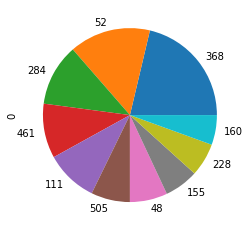

In [12]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

**(5). Defining our model and splitting the dataset:**
* We need to split the training set for validation.

In [14]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,
                                                 clearalllabels,
                                                 test_size=0.1,
                                                 random_state=seed,
                                                 stratify=clearalllabels)

**(6). Preventing Overfitting:**
* To prevent overfitting, we need to create a function that can randomly change image characterisitics during fitting.

In [15]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,
                               width_shift_range = 0.1,height_shift_range = 0.1,
                               horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

**(7). Defining the Convolutional Neural Network:**
* This model has 4 convolution layers.
* This model has 3 fully connected layers.

In [16]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)     

**(8). Fitting the CNN onto the data:**
* We have to set a few callbacks:
    * We have to reduce the learning rate because, convergence will be much quicker.
    * We have to save the best weights of the model.
    * We have to save the last weights of the model.    

In [17]:
# Set up checkpoints, callbacks and reducing learning rate
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

filepath="data/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')
filepath="data/weights.last_auto4.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoints, lrr, checkpoints_full]

In [18]:
#Model
# hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=75), 
#                            epochs=35, validation_data=(testX, testY), 
#                            steps_per_epoch=trainX.shape[0], callbacks=callbacks_list)

# Load model
# model.load_weights("data/weights.best_17-0.96.hdf5")
# dataset = np.load("data/Data.npz")
# data = dict(zip(("x_train","x_test","y_train", "y_test"), (dataset[k] for k in dataset)))
#x_train = data['x_train']
#x_test = data['x_test']
#y_train = data['y_train']
#y_test = data['y_test']

print(model.evaluate(x_train, y_train))  # Evaluate on train set
print(model.evaluate(x_test, y_test))  # Evaluate on test set


40841/40841 [==============================] - 1656s 41ms/step
[2.302377088299747, 0.12950222194194794]
4538/4538 [==============================] - 184s 40ms/step
[2.302412575065643, 0.1293521374464035]


**(9). Confusion Matrix:**
* The confusion matrix is one of the best ways to analyse the errors in the model.
* It gives the exact number of correct and incorrect predictions

In [20]:
# Prediction
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[227   0   6   3   4   5  20   1   3 173]
 [149   1   4   3   4   7  12   0   2 104]
 [126   2   8   2   1   7  19   1   0  85]
 [156   2   1   3   3   4  16   1   1  93]
 [284   1  11   6   4   8  28   0   1 179]
 [420   1  15   9  14  14  57   2   5 430]
 [235   0   5   8   4   4  26   1   0 177]
 [201   0   8   0   5   6  14   0   2  81]
 [164   0   4   1   2   4  29   0   0 124]
 [299   3  10   1   8  15  41   0   4 304]]


 **(10). Process the testing set and getting predictions:**

In [19]:
path_to_test = 'data/test/*/*.jpg'
pics = glob(path_to_test)

testimages = []
tests = []
count=1
num = len(pics)

for i in pics:
    print(str(count)+'/'+str(num),end='\r')
    tests.append(i.split('/')[-1])
    testimages.append(cv2.resize(cv2.imread(i),(scale,scale)))
    count = count + 1

testimages = np.asarray(testimages)

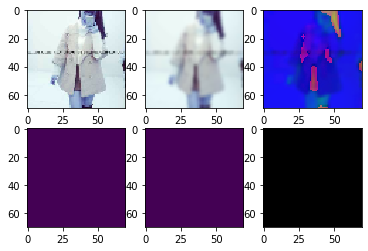

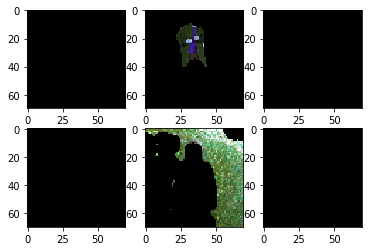

In [21]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False

newtestimages = np.asarray(newtestimages)
# Other masked images
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])

In [15]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)

# Prediction to a csv file
pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]
result = {'file':tests,'category':predStr}
result = pd.DataFrame(result)
result.to_csv("Prediction.csv",index=False)